In [61]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [62]:
import tensorflow.keras as K
(x_tr, y_tr), (x_te, y_te) = K.datasets.mnist.load_data()

x_tr = np.reshape(x_tr.astype(np.float32),(x_tr.shape[0],1,*x_tr.shape[1:]))
x_te = np.reshape(x_te.astype(np.float32),(x_te.shape[0],1,*x_te.shape[1:]))
y_tr = K.utils.to_categorical(y_tr)
y_te = K.utils.to_categorical(y_te)

In [72]:
# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 16

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
num_epochs = 32

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.35

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [73]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [74]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [75]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.linear1 = nn.Linear(100,128*7*7)
        self.conv1 = nn.ConvTranspose2d(128, ngf * 8, 4, 2,1, bias=True)
        self.batch1 = nn.BatchNorm2d(ngf * 8)
        
        #nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        
        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.batch2 = nn.BatchNorm2d(ngf * 4)
        #nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        self.conv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 3, 1, 1, bias=False)
        self.batch3 = nn.BatchNorm2d(ngf * 2)
        #nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        self.conv4 = nn.ConvTranspose2d( ngf * 2, ngf, 3,1, 1, bias=False)
        self.batch4 = nn.BatchNorm2d(ngf)
        #nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        self.conv5 = nn.ConvTranspose2d( ngf, nc, 3, 1, 1, bias=False)
        #nn.Tanh()

    def forward(self, input):
        #return self.main(torch.reshape(input,(-1,128,7,7)))
        x = self.linear1(input)
        x = torch.reshape(x,(-1,128,7,7))
        x = self.conv1(x)
        x = self.batch1(x)
        x = nn.ReLU(True)(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = nn.ReLU(True)(x)
        
        x = self.conv3(x)
        x = self.batch3(x)
        x = nn.ReLU(True)(x)
        
        x = self.conv4(x)
        x = self.batch4(x)
        x = nn.ReLU(True)(x)
        
        x = self.conv5(x)
        x = nn.ReLU(True)(x)
        return x

In [76]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (linear1): Linear(in_features=100, out_features=6272, bias=True)
  (conv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


In [77]:
summary(netG,(1,nz))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 6272]         633,472
   ConvTranspose2d-2          [-1, 128, 14, 14]         262,272
       BatchNorm2d-3          [-1, 128, 14, 14]             256
   ConvTranspose2d-4           [-1, 64, 28, 28]         131,072
       BatchNorm2d-5           [-1, 64, 28, 28]             128
   ConvTranspose2d-6           [-1, 32, 28, 28]          18,432
       BatchNorm2d-7           [-1, 32, 28, 28]              64
   ConvTranspose2d-8           [-1, 16, 28, 28]           4,608
       BatchNorm2d-9           [-1, 16, 28, 28]              32
  ConvTranspose2d-10            [-1, 1, 28, 28]             144
Total params: 1,050,480
Trainable params: 1,050,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.78
Params size (MB): 4.01
Estimat

In [78]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d((2,2)),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d((2,2)),
            # state size. (ndf*2) x 16 x 16
            #nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            #nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf *2, ndf * 4, 1, 1, 1, bias=False),
            nn.MaxPool2d((2,2)),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(1024,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [79]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Sigmoid()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=1, bias=True)
    (12): Sigmoid()
  )
)


In [80]:
summary(netD,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
         LeakyReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,608
       BatchNorm2d-5           [-1, 32, 14, 14]              64
         LeakyReLU-6           [-1, 32, 14, 14]               0
         MaxPool2d-7             [-1, 32, 7, 7]               0
            Conv2d-8             [-1, 64, 9, 9]           2,048
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Sigmoid-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                    [-1, 1]           1,025
          Sigmoid-13                    [-1, 1]               0
Total params: 7,889
Trainable params: 7

In [81]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [88]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for j in range(0,y_tr.shape[0]-batch_size,batch_size):
        data = torch.tensor(x_tr[j:j+batch_size])
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if j % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, j, x_tr.shape[0],
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (j > x_tr.shape[0]-batch_size-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/32][0/60000]	Loss_D: 1.3926	Loss_G: 0.7973	D(x): 0.4754	D(G(z)): 0.4736 / 0.4524
[0/32][6400/60000]	Loss_D: 1.3796	Loss_G: 0.7651	D(x): 0.4637	D(G(z)): 0.4538 / 0.4661
[0/32][12800/60000]	Loss_D: 1.3694	Loss_G: 0.6656	D(x): 0.4768	D(G(z)): 0.4634 / 0.5152
[0/32][19200/60000]	Loss_D: 1.3944	Loss_G: 0.5970	D(x): 0.4665	D(G(z)): 0.4638 / 0.5521
[0/32][25600/60000]	Loss_D: 1.3720	Loss_G: 0.8463	D(x): 0.5225	D(G(z)): 0.5115 / 0.4313
[0/32][32000/60000]	Loss_D: 1.3945	Loss_G: 0.6880	D(x): 0.5057	D(G(z)): 0.5070 / 0.5035
[0/32][38400/60000]	Loss_D: 1.3786	Loss_G: 0.6969	D(x): 0.5084	D(G(z)): 0.5019 / 0.4989
[0/32][44800/60000]	Loss_D: 1.3789	Loss_G: 0.7037	D(x): 0.4992	D(G(z)): 0.4924 / 0.4958
[0/32][51200/60000]	Loss_D: 1.3891	Loss_G: 0.4758	D(x): 0.4119	D(G(z)): 0.3895 / 0.6245
[0/32][57600/60000]	Loss_D: 1.3689	Loss_G: 0.7842	D(x): 0.5054	D(G(z)): 0.4926 / 0.4585
[1/32][0/60000]	Loss_D: 1.3995	Loss_G: 0.5652	D(x): 0.4432	D(G(z)): 0.4351 / 0.5709
[1/32][6400/600

In [89]:
noise = torch.randn(16, nz, device=device)
fake = netG(noise).to(torch.device("cpu")).detach().numpy()

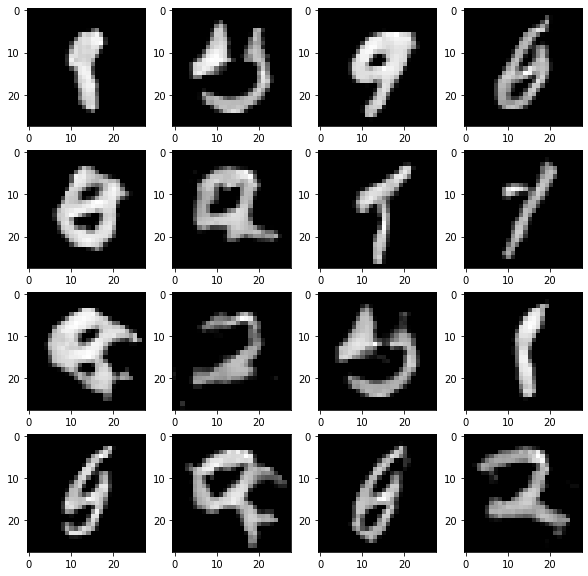

In [90]:
fig,ax = plt.subplots(4,4)
fig.set_size_inches(10,10)
for i in range(16):
    ax.flatten()[i].imshow(fake[i][0],'gray')

In [54]:
noise.shape

torch.Size([16, 100, 1, 1])